In [151]:
import numpy as np
import xarray as xr
from pyresample import geometry, kd_tree

from matplotlib import pyplot as plt
import ecco_v4_py as ecco

In [152]:
llc90_ds = xr.open_dataset("/Users/marlis/Developer/ECCO/ECCO-pipeline/ecco_pipeline/grids/ECCO_llc90.nc")
lon_grid = llc90_ds.XC.values  # shape (ny, nx)
lat_grid = llc90_ds.YC.values
lon_flat = lon_grid.ravel()
lat_flat = lat_grid.ravel()

In [153]:
at_ds = xr.open_dataset("/Users/marlis/Developer/Measures-Cloud/data/updated_df_delivery/NASA-SSH_alt_ref_at_v1_20250805.nc")
lat_points = at_ds.latitude.values
lon_points = at_ds.longitude.values
lon_points = np.mod(lon_points + 180, 360) - 180
values = at_ds.ssha_smoothed.values

# Nearest neighbor

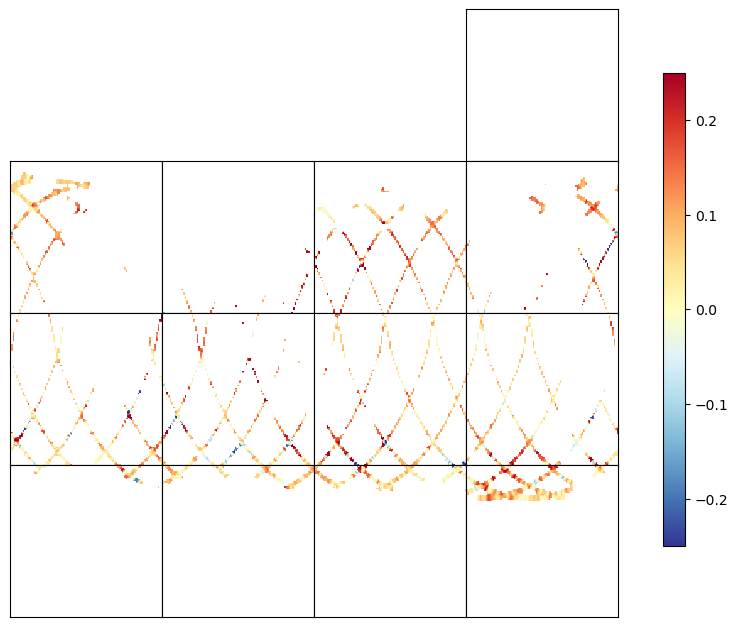

In [159]:
swath_def = geometry.SwathDefinition(lons=lon_points, lats=lat_points)
target_def = geometry.SwathDefinition(lons=lon_flat, lats=lat_flat)

roi = 100000
sla_flat = kd_tree.resample_nearest(
    swath_def, 
    values, 
    target_def,
    radius_of_influence=roi,
    fill_value=np.nan
)

# Reshape back to tiled ECCO grid
sla_on_grid = sla_flat.reshape(lon_grid.shape)

counts_flat = kd_tree.resample_nearest(
    swath_def, np.ones_like(values), target_def,
    radius_of_influence=roi,
    fill_value=0
)
counts = counts_flat.reshape(lon_grid.shape)

min_points = 1
sla_on_grid_masked = np.where(counts >= min_points, sla_on_grid, np.nan)

sla_ds = xr.full_like(llc90_ds, np.nan)
sla_ds["ssha"] = (("tile", "j", "i"), sla_on_grid_masked)

ecco.plot_tiles(
    sla_ds["ssha"],
    cmin=-.25,
    cmax=.25,
    cmap="RdYlBu_r",
    show_colorbar=True,
    layout="latlon",
    show_tile_labels=False,
    rotate_to_latlon=True,
    Arctic_cap_tile_location=10,
)
plt.show()

# Cell search

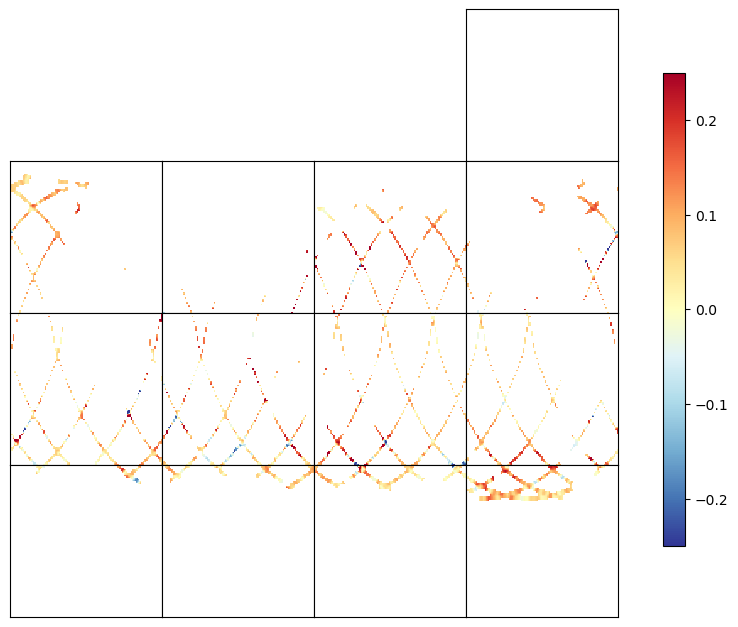

In [164]:
# Source: along-track points
source_def = geometry.SwathDefinition(lons=lon_points, lats=lat_points)

# Target: ECCO LLC90 grid flattened
target_def = geometry.SwathDefinition(lons=lon_flat, lats=lat_flat)

# Radius cutoff (e.g. 100 km)
roi = 100000

def ones_weight(distances):
    return np.ones_like(distances, dtype=float)

def gaussian_weight(distances, sigma=50000):  # sigma in meters
    return np.exp(-(distances**2) / (2 * sigma**2))

# Apply resampling
sla_flat = kd_tree.resample_custom(
    source_def, values, target_def,
    radius_of_influence=roi,
    neighbours=16,        # number of neighbors to search
    weight_funcs=ones_weight,    # None = equal weights
    fill_value=np.nan,
    # reduce_func=mean_func
)

# Reshape back to tile structure
sla_on_grid = sla_flat.reshape(lon_grid.shape)

counts_flat = kd_tree.resample_nearest(
    source_def, np.ones_like(values), target_def,
    radius_of_influence=roi,
    fill_value=0
)
counts = counts_flat.reshape(lon_grid.shape)

min_points = 1
sla_on_grid_masked = np.where(counts >= min_points, sla_on_grid, np.nan)

sla_ds = xr.full_like(llc90_ds, np.nan)
sla_ds["ssha"] = (("tile", "j", "i"), sla_on_grid_masked)

ecco.plot_tiles(
    sla_ds["ssha"],
    cmin=-.25,
    cmax=.25,
    cmap="RdYlBu_r",
    show_colorbar=True,
    layout="latlon",
    show_tile_labels=False,
    rotate_to_latlon=True,
    Arctic_cap_tile_location=10,
)
plt.show()